In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import AgglomerativeClustering

import warnings

from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import collections

## Load the data

In [2]:
df = pd.read_csv("abstractdata5.csv", sep="#")
df.columns = ["id", "class", "title", "abstract"]
df.head(5)

,id,class,title,abstract
0,id2,1,Person re-identification with deep kronecker-p...,Person re-identification (re-ID) aims to robus...
1,id3,1,Crack detection in images of masonry using cnns,While there is a significant body of research ...
2,id4,5,Towards an energy efficient code generator for...,Using a smartphone become the part of our ever...
3,id5,5,Sub-polyhedral scheduling using (Unit-)two-var...,Polyhedral compilation has been successful in ...
4,id6,2,Extracting multiple viewpoint models from rela...,Much time in process mining projects is spent ...


### Combine the title with abstract, and lower case the sentences:

In [3]:
df["TitleWithAbstract"] = df["title"] + " " + df["abstract"]
df["TitleWithAbstract"] = df["TitleWithAbstract"].str.lower()

### Remove the stopwords:

In [4]:
stop_words = set(stopwords.words('english'))
punctuation_tokenizer = nltk.RegexpTokenizer(r"\w+")

df["tokenized"] = df["TitleWithAbstract"].apply(lambda x: punctuation_tokenizer.tokenize(x))

In [5]:
df["non_stop_words"] = ""

In [6]:
for idx, row in df.iterrows():
    # Get the sentence
    token_sentence = row["tokenized"]
    filter_sentence = []
    for word in token_sentence:
        if word.lower() not in stop_words:
            filter_sentence.append(word)
            
    # Reappend to the dataframe
    df["non_stop_words"][idx] = filter_sentence

### Stem remaining words

In [7]:
df["stemmed"] = ""

In [8]:
from nltk.stem import WordNetLemmatizer

snowball_stemmer = WordNetLemmatizer()

for idx, row in df.iterrows():
    non_stop_words = row["non_stop_words"]
    stemmed_words = []
    for word in non_stop_words:
        stemmed = snowball_stemmer.lemmatize(word)
        stemmed_words.append(stemmed)
    # Reappend to the dataframe
    df["stemmed"][idx] = stemmed_words

In [9]:
from nltk.stem import SnowballStemmer

snowball_stemmer = SnowballStemmer("english")

for idx, row in df.iterrows():
    non_stop_words = row["non_stop_words"]
    stemmed_words = []
    for word in non_stop_words:
        stemmed = snowball_stemmer.stem(word)
        stemmed_words.append(stemmed)
    # Reappend to the dataframe
    df["stemmed"][idx] = stemmed_words

In [10]:
# For tf-idf calculation
stemmed_df = df[["id", "class", "stemmed"]]
stemmed_df

,id,class,stemmed
0,id2,1,"[person, identif, deep, kroneck, product, matc..."
1,id3,1,"[crack, detect, imag, masonri, use, cnns, sign..."
2,id4,5,"[toward, energi, effici, code, generat, mobil,..."
3,id5,5,"[sub, polyhedr, schedul, use, unit, two, varia..."
4,id6,2,"[extract, multipl, viewpoint, model, relat, da..."
...,...,...,...
1326,id1328,1,"[colorimetr, point, care, paper, base, sensor,..."
1327,id1329,1,"[calcium, identif, score, base, echocardiograp..."
1328,id1330,1,"[consid, filter, import, irreplac, filter, pru..."
1329,id1331,4,"[low, complex, bit, serial, sequenti, polynomi..."


In [11]:
stemmed_df["sentence"] = ""

In [12]:
for idx, row in stemmed_df.iterrows():
    tokens = row["stemmed"]
    sentences = " ".join(w for w in tokens)
    stemmed_df.loc[idx, "sentence"] = sentences

## K-Means modeling:

### Naive K-Means

In [14]:
ground_truth_labels = df["class"]

tfidf = TfidfVectorizer(
    stop_words = 'english'
)
text = tfidf.fit_transform(stemmed_df.sentence)
#representation[n_gram] = text

# Initialize the KMeans
clusters = KMeans(n_clusters=5, random_state=42).fit_predict(text)

# Calculate NMI
nmi_average = normalized_mutual_info_score(ground_truth_labels, clusters, average_method = "geometric")
nmi_average = round(nmi_average, 4)

print("K-Means with Tfidf (without n_gram or other parameter modifications)")
print("NMI: {}".format(nmi_average))

K-Means with Tfidf (without n_gram or other parameter modifications)
NMI: 0.6634


### K-Means with LSA

In [16]:
possible_ngram = [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)]
ground_truth_labels = df["class"]


nmi = collections.defaultdict(dict)
tf_idf = collections.defaultdict(dict)
k_means = collections.defaultdict(dict)
hierarchical = collections.defaultdict(dict)
tfidf_matrix = collections.defaultdict(dict)


threshold = [10,15,20]

print("K-Means with LSA:")
for i in threshold:
    print("Threshold {}".format(i))
    for n_gram in possible_ngram:
        tfidf = TfidfVectorizer(
            stop_words = 'english', min_df = i, ngram_range = n_gram, sublinear_tf=True
        )
        text = tfidf.fit_transform(stemmed_df.sentence)
        #representation[n_gram] = text

        svd = TruncatedSVD(n_components = 5)
        normalizer = Normalizer(copy=False)
        lsa = make_pipeline(svd, normalizer)

        text_transformed = lsa.fit_transform(text)

        clusters = KMeans(n_clusters=5, random_state=42).fit_predict(text_transformed)
        
        #cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward', compute_distances=True)
        #predictions = cluster.fit_predict(text.toarray())
        
        nmi_average = normalized_mutual_info_score(ground_truth_labels, clusters, average_method = "geometric")
        nmi_average = round(nmi_average, 4)
        #nmi_average = normalized_mutual_info_score(ground_truth_labels, clusters, average_method = "geometric")
        nmi[i][n_gram] = nmi_average
        #k_means[n_gram] = clusters
        #hierarchical[i][n_gram] = cluster
        tf_idf[i][n_gram] = tfidf
        tfidf_matrix[i][n_gram] = text
            
        print("NMI {}: {}".format(n_gram, nmi_average))
    print()

K-Means with LSA:
Threshold 10
NMI (1, 1): 0.8203
NMI (1, 2): 0.8166
NMI (1, 3): 0.8138
NMI (2, 2): 0.3973
NMI (2, 3): 0.4087
NMI (3, 3): 0.1832

Threshold 15
NMI (1, 1): 0.8121
NMI (1, 2): 0.8122
NMI (1, 3): 0.8051
NMI (2, 2): 0.3163
NMI (2, 3): 0.2952
NMI (3, 3): 0.1388

Threshold 20
NMI (1, 1): 0.8114
NMI (1, 2): 0.8136
NMI (1, 3): 0.8149
NMI (2, 2): 0.2324
NMI (2, 3): 0.2522
NMI (3, 3): 0.1706



In [18]:
possible_ngram = [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)]
ground_truth_labels = df["class"]

import collections
nmi = collections.defaultdict(dict)
tf_idf = collections.defaultdict(dict)
k_means = collections.defaultdict(dict)

threshold = [10,20,30]

print("K-Means with improved tfidf(with n-gram, min_df, and sublinear_tf modifications)")
for i in threshold:
    print("Threshold {}".format(i))
    for n_gram in possible_ngram:
        tfidf = TfidfVectorizer(
            stop_words = 'english', min_df = i, ngram_range = n_gram, sublinear_tf = True
        )
        text = tfidf.fit_transform(stemmed_df.sentence)
        #representation[n_gram] = text

        # Initialize the KMeans
        clusters = KMeans(n_clusters=5, random_state = 42)
        pred = clusters.fit_predict(text)

        # Calculate NMI
        nmi_average = normalized_mutual_info_score(ground_truth_labels, pred, average_method = "geometric")

        nmi[i][n_gram] = nmi_average
        k_means[i][n_gram] = clusters
        tf_idf[i][n_gram] = tfidf

        print("NMI {}: {}".format(n_gram, round(nmi_average,4)))
    print()

K-Means with improved tfidf(with n-gram, min_df, and sublinear_tf modifications)
Threshold 10
NMI (1, 1): 0.8088
NMI (1, 2): 0.8176
NMI (1, 3): 0.8108
NMI (2, 2): 0.4178
NMI (2, 3): 0.3293
NMI (3, 3): 0.138

Threshold 20
NMI (1, 1): 0.8339
NMI (1, 2): 0.8187
NMI (1, 3): 0.8162
NMI (2, 2): 0.3234
NMI (2, 3): 0.3217
NMI (3, 3): 0.1398

Threshold 30
NMI (1, 1): 0.8251
NMI (1, 2): 0.8132
NMI (1, 3): 0.8092
NMI (2, 2): 0.2808
NMI (2, 3): 0.2826
NMI (3, 3): 0.122



C:\Users\k64102259\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


### Topic Inference

Below is an auxiliary function for getting the top keywords for each cluster. It is useful for inferring what is the topic of the cluster: 

In [19]:
df_freq = stemmed_df.copy()
topic_1 = df_freq[df_freq["class"] == 1]
topic_2 = df_freq[df_freq["class"] == 2]
topic_3 = df_freq[df_freq["class"] == 3]
topic_4 = df_freq[df_freq["class"] == 4]
topic_5 = df_freq[df_freq["class"] == 5]

In [20]:
topic_1["sentence"] = ""
topic_2["sentence"] = ""
topic_3["sentence"] = ""
topic_4["sentence"] = ""
topic_5["sentence"] = ""

In [21]:
for idx, row in topic_1.iterrows():
    sentence = ' '.join(row.stemmed)
    topic_1["sentence"][idx] = sentence
    
for idx, row in topic_2.iterrows():
    sentence = ' '.join(row.stemmed)
    topic_2["sentence"][idx] = sentence
    
for idx, row in topic_3.iterrows():
    sentence = ' '.join(row.stemmed)
    topic_3["sentence"][idx] = sentence
    
for idx, row in topic_4.iterrows():
    sentence = ' '.join(row.stemmed)
    topic_4["sentence"][idx] = sentence

for idx, row in topic_5.iterrows():
    sentence = ' '.join(row.stemmed)
    topic_5["sentence"][idx] = sentence

In [22]:
freq_count_1 = topic_1.sentence.str.split(expand=True).stack().value_counts()
freq_count_2 = topic_2.sentence.str.split(expand=True).stack().value_counts()
freq_count_3 = topic_3.sentence.str.split(expand=True).stack().value_counts()
freq_count_4 = topic_4.sentence.str.split(expand=True).stack().value_counts()
freq_count_5 = topic_5.sentence.str.split(expand=True).stack().value_counts()

In [23]:
freq_count = [freq_count_1, freq_count_2, freq_count_3, freq_count_4, freq_count_5]

In [24]:
print("Top terms per cluster:")
order_centroids = k_means[20][1,2].cluster_centers_.argsort()[:, ::-1]
terms = tf_idf[20][1,2].get_feature_names()


for index,freq_count_df in enumerate(freq_count):
    print("Cluster {}:".format(index+1))
    for ind in order_centroids[index, :10]:
        # Extract the frequency of the words
        word = terms[ind]
        if word in ["comput vision", 'relat databas']:
            continue
        frequency = freq_count_df[word]
        print('%s' % word, frequency)
    print()

Top terms per cluster:
Cluster 1:
imag 632
detect 446
vision 383
method 500
learn 361
deep 238
base 511
use 621
model 425

Cluster 2:
databas 678
relat 406
data 609
queri 272
sql 107
inform 195
manag 114
use 301
model 227

Cluster 3:
robot 883
control 325
use 365
task 167
perform 213
simul 118
environ 128
soft 116
approach 156
model 204

Cluster 4:
compil 1
program 9
languag 2
code 35
optim 60
comput 208
use 400
graph 8
implement 180
parallel 12

Cluster 5:
secur 55
encrypt 8
cryptographi 4
scheme 31
key 23
attack 9
protocol 23
propos 122
quantum 149
base 232



In [25]:
count_1 =collections.Counter()
count_2 =collections.Counter()

# For 2-gram "comput vision" term
for i in topic_1.sentence:
  x = i.rstrip().split(" ")
  count_1.update(set(zip(x[:-1],x[1:])))
    
print("Frequency of 2-gram comput vision:", count_1["comput", "vision"])

# For 2-gram "relat database" term
for i in topic_2.sentence:
  x = i.rstrip().split(" ")
  count_2.update(set(zip(x[:-1],x[1:])))
    
print("Frequency of 2-gram relat databas:", count_2["relat", "databas"])

Frequency of 2-gram comput vision: 160
Frequency of 2-gram relat databas: 139


## Agglomerative Hierarchical Clustering 

### Naive Agglomerative Hierarchical Clustering

In [26]:
ground_truth_labels = df["class"]

threshold = [10,15,20]

print("Naive Agglomerative Hierarchical Clustering with Ward linkage:")

tfidf = TfidfVectorizer(
    stop_words = 'english'
)
text = tfidf.fit_transform(stemmed_df.sentence)

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward', compute_distances=True)
predictions = cluster.fit_predict(text.toarray())

nmi_average = normalized_mutual_info_score(ground_truth_labels, predictions, average_method = "geometric")
nmi_average = round(nmi_average, 4)

print("NMI: {}".format(nmi_average))
print()

Naive Agglomerative Hierarchical Clustering with Ward linkage:
NMI: 0.4347



In [28]:
possible_ngram = [(1,1), (1,2), (1,3), (2,2), (2,3), (3,3)]
ground_truth_labels = df["class"]


nmi = collections.defaultdict(dict)
tf_idf = collections.defaultdict(dict)
k_means = collections.defaultdict(dict)
hierarchical = collections.defaultdict(dict)
tfidf_matrix = collections.defaultdict(dict)

threshold = [10,20,30]

print("Agglomerative Hierarchical Clustering with Ward linkage and with improved tfidf(with n-gram, min_df, and sublinear_tf modifications):")
for i in threshold:
    print("Threshold {}".format(i))
    for n_gram in possible_ngram:
        tfidf = TfidfVectorizer(
            stop_words = 'english', min_df = i, ngram_range = n_gram, sublinear_tf=True
        )
        text = tfidf.fit_transform(stemmed_df.sentence)

        cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward', compute_distances=True)
        predictions = cluster.fit_predict(text.toarray())
        
        nmi_average = normalized_mutual_info_score(ground_truth_labels, predictions, average_method = "geometric")
        nmi_average = round(nmi_average, 4)
        #nmi_average = normalized_mutual_info_score(ground_truth_labels, clusters, average_method = "geometric")
        nmi[i][n_gram] = nmi_average
        #k_means[n_gram] = clusters
        hierarchical[i][n_gram] = cluster
        tf_idf[i][n_gram] = tfidf
        tfidf_matrix[i][n_gram] = text
            
        print("NMI {}: {}".format(n_gram, nmi_average))
    print()

Agglomerative Hierarchical Clustering with Ward linkage and with improved tfidf(with n-gram, min_df, and sublinear_tf modifications):
Threshold 10
NMI (1, 1): 0.5787
NMI (1, 2): 0.5972
NMI (1, 3): 0.6018
NMI (2, 2): 0.2642
NMI (2, 3): 0.2895
NMI (3, 3): 0.1104

Threshold 20
NMI (1, 1): 0.6074
NMI (1, 2): 0.6111
NMI (1, 3): 0.614
NMI (2, 2): 0.2241
NMI (2, 3): 0.2341
NMI (3, 3): 0.1679

Threshold 30
NMI (1, 1): 0.5827
NMI (1, 2): 0.5672
NMI (1, 3): 0.5913
NMI (2, 2): 0.2575
NMI (2, 3): 0.254
NMI (3, 3): 0.1206



In [29]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

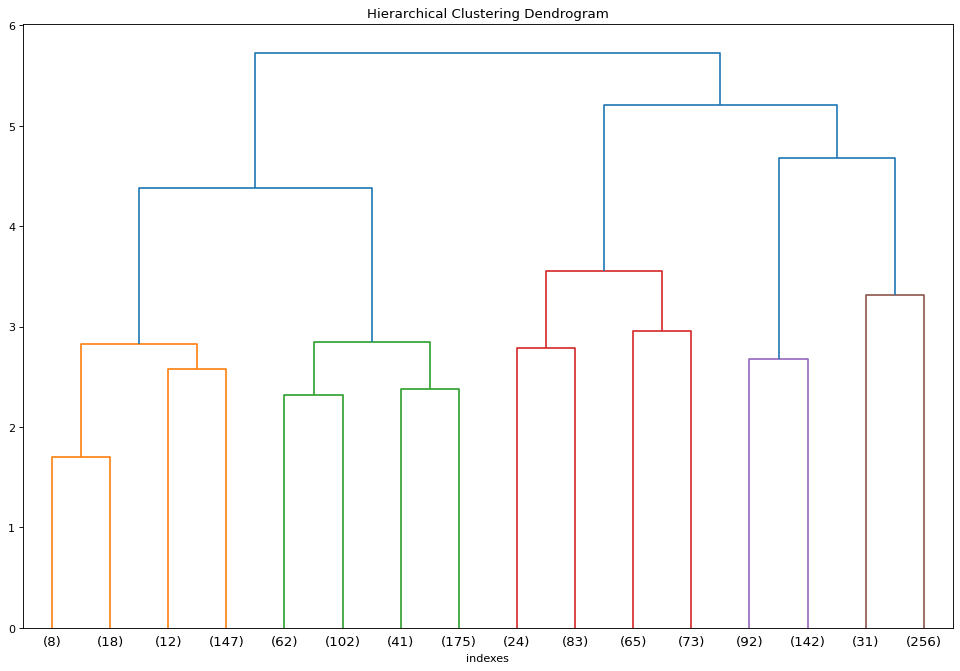

In [30]:
from matplotlib.pyplot import figure
from scipy.cluster.hierarchy import ward, dendrogram
import matplotlib.pyplot as plt

figure(figsize=(15, 10), dpi=80)
best_nmi_hierarchical = hierarchical[20][1,3]

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(best_nmi_hierarchical, truncate_mode="level", p=3)
plt.xlabel("indexes")
plt.show()

In [31]:
result = df.copy()
result = result[["id","class","TitleWithAbstract"]]

In [32]:
result.iloc[[8,18,12,147,62,102,41,175,24,83,65,73,92,142,31,256],:]

,id,class,TitleWithAbstract
8,id10,3,mask then classify: multi-instance segmentatio...
18,id20,1,attention monitoring for synchronous distance ...
12,id14,5,partial flow sensitivity compiler optimization...
147,id149,2,online tourism system for proposals formation ...
62,id64,2,moving recursion out of the rdbms for transact...
102,id104,4,quantum search for scaled hash function preima...
41,id43,3,coordinate ascent more with adaptive entropy c...
175,id177,1,effect of loss functions on domain adaptation ...
24,id26,2,centralized clinical trial imaging data manage...
83,id85,2,managing technical debt in database normalizat...
